# GAN（生成对抗式网络）

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.fft as fft
import os
from tqdm import tqdm # 打印进度条
import math
from einops import rearrange, repeat, reduce
from scipy.fftpack import next_fast_len
import matplotlib.pyplot as plt
import functools
from functools import partial, wraps
from sympy import Poly, legendre, Symbol, chebyshevt
from scipy.special import eval_legendre
from scipy import signal
from torch.nn.modules.linear import Linear
from torch.nn.utils import weight_norm 
from operator import mul
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
import joblib
# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

import warnings

warnings.filterwarnings("ignore")

## 基本概念

GAN的全称是Generative adversarial network，中文翻译过来就是生成对抗网络。生成对抗网络其实是两个网络的组合：生成网络（Generator）负责生成模拟数据；判别网络（Discriminator）负责判断输入的数据是真实的还是生成的。生成网络要不断优化自己生成的数据让判别网络判断不出来，判别网络也要优化自己让自己判断得更准确。二者关系形成对抗，因此叫对抗网络。

GAN通过对某一事物大量数据的学习，来学习总结出其在数学层面上的分布规律，构建出合理的映射函数，从而解决现实问题。

![示例图片](../images/p40.png)

生成器(Generator)：通过机器生成数据（大部分情况下是图像），最终目的是“骗过”判别器。

判别器(Discriminator)：判断这张图像是真实的还是机器生成的，目的是找出生成器做的“假数据”。

生成器生成假数据，然后将生成的假数据和真数据都输入判别器，判别器要判断出哪些是真的哪些是假的。判别器第一次判别出来的肯定有很大的误差，然后我们根据误差来优化判别器。现在判别器水平提高了，生成器生成的数据很难再骗过判别器了，所以我们得反过来优化生成器，之后生成器水平提高了，然后反过来继续训练判别器，判别器水平又提高了，再反过来训练生成器，就这样循环往复，直到达到纳什均衡。

**生成网络的损失函数：**
$$L_G=H(1,D(G(z)))$$
上式中，$G$ 代表生成网络，$D $代表判别网络，$H$ 代表交叉熵，$z$ 是输入随机数据。$D(G(z))$是对生成数据的判断概率，1代表数据绝对真实，0代表数据绝对虚假。$H(1,D(G(z)))$代表判断结果与1的距离。显然生成网络想取得良好的效果，那就要做到，让判别器将生成数据判别为真数据（即$D(G(z))$与1的距离越小越好）。

**判别网络的损失函数：**
$$L_D=H(1,D(x))+H(0,D(G(z)))$$
上式中，$x$是真实数据，这里要注意的是，$H(1,D(x))$代表真实数据与1的距离，$H(0,D(G(z)))$代表生成数据与0的距离。显然，识别网络要想取得良好的效果，那么就要做到，在它眼里，真实数据就是真实数据，生成数据就是虚假数据（即真实数据与1的距离小，生成数据与0的距离小）。
 

**优化原理**：生成网络和判别网络有了损失函数，就可以基于各自的损失函数，利用误差反向传播（Backpropagation）(BP)反向传播算法和最优化方法(如梯度下降法)来实现参数的调整），不断提高生成网络和判别网络的性能（最终生成网络和判别网络的成熟状态就是学习到了合理的映射函数）。

## WGAN

### Wasserstein距离

WGAN引入了Wasserstein距离（也称为地雷杰斯坦距离或汉明斯坦距离）作为GAN的目标函数，用于衡量真实分布和生成分布之间的差异。Wasserstein距离具有更好的数学性质，尤其是当两个分布有重叠时，它依然是可导的。这使得训练过程更加稳定，避免了传统GAN中 Jensen-Shannon 散度等指标可能出现的问题。


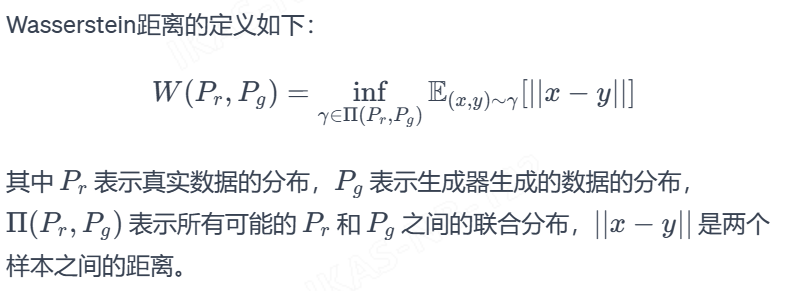

### 梯度裁剪

梯度裁剪（Gradient Clipping）是深度学习中的一种优化技术，主要用于防止梯度爆炸的问题。当神经网络训练时，梯度值可能变得非常大，导致权重更新过大，进而影响模型的稳定性和收敛性。梯度裁剪通过限制梯度的大小，防止它们超过设定的阈值，从而解决这个问题。

在实践中，梯度裁剪通常在每个训练迭代之后应用于模型的梯度。具体步骤如下：

- 计算模型参数关于损失函数的梯度。
- 计算梯度的范数（通常是L2范数）。
- 如果梯度的范数超过了预先设定的阈值，就按比例缩放梯度，使其范数等于阈值。
梯度裁剪的公式如下：

$$clipped_{gradient}=\frac{threshold}{||gradients||}×gradients$$

其中，threshold 是设定的梯度阈值，gradients 是计算得到的梯度。

梯度裁剪有助于避免梯度爆炸的问题，提高模型的稳定性和训练效果。这一技术通常用于循环神经网络（Recurrent Neural Networks，RNN）等架构，因为它们更容易受到梯度爆炸的影响。在许多深度学习框架中，梯度裁剪往往可以通过设置相应的参数或调用相应的函数来实现。

## 数据准备

In [2]:
# 读取数据
def get_dataset(data_path=None, data=None, time_col=None):
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [3]:
data_path = "../test/datasets/energy.csv"
ts_data = get_dataset(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
...,...,...
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00
2014-12-31 22:00:00,"3,499.00",15.33


In [1]:
# 包含时间维度的数据集划分
def divide_dataset(df, test_date, valid_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [4]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [5]:
# 生成tensor数据
def rnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader，drop_last这个是对最后的未完成的batch来说的，后面剩余的不够batch_size的会丢弃
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size, drop_last=True)
    return X, y, loader

In [6]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "step": 1,
    "batch_size": 64,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 2]),y_size: torch.Size([23370, 6, 2]),loader_len: 365
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 22
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 22


## 结果分析

In [7]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GANs")
    plt.legend(["Generator loss", "Discriminator loss"])
    plt.show()

## 模型训练

In [216]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(train_loader, valid_loader, n_epochs, clip_value=0.01, verbose=True, plots=True):
    # 定义生成器
    class Generator(nn.Module):
        def __init__(self, input_dim, hidden_dim, out_dim, dropout_prob=0.5):
            super(Generator, self).__init__()
            # 输入维度为 (batch_size, input_dim, seq_length)
            self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv1d(hidden_dim, out_dim, kernel_size=3, stride=1, padding=1)
            self.dropout = nn.Dropout(p=dropout_prob)

        def forward(self, x):
            x = x.permute(0, 2, 1)
            out = self.dropout(torch.relu(self.conv1(x)))
            out = self.dropout(torch.relu(self.conv2(out)))
            out = out.permute(0, 2, 1)
            return out

    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim, extra_linear_dim, dropout_prob=0.5):
            super(Discriminator, self).__init__()
            self.linear1 = nn.Linear(input_dim, hidden_dim)
            self.linear2 = nn.Linear(hidden_dim, extra_linear_dim)
            self.linear3 = nn.Linear(extra_linear_dim, 1)
            self.dropout = nn.Dropout(dropout_prob)

        def forward(self, x):
            out = self.linear1(x)
            out = self.dropout(out)
            out = self.linear2(out)
            out = self.dropout(out)
            out = self.linear3(out)
            return out

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    input_dim = 2  # 输入数据的维度
    hidden_dim = 128  # LSTM层的隐藏单元数
    out_dim = 2  # 输出数据的维度
    extra_linear_dim = 64  # 额外的线性层维度
    batch_size = 64
    seq_length = 6
    lr = 0.00001  # 学习率

    generator = Generator(input_dim, hidden_dim, out_dim)
    discriminator = Discriminator(input_dim, hidden_dim, extra_linear_dim)

    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

    # 损失函数值
    G_losses, D_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        generator.train()
        discriminator.train()
        total_G_loss = 0
        total_D_loss = 0
        for inputs_batch, targets_batch in train_loader:
            # 将输入数据和标签移至GPU
            inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)

            # 训练生成器
            optimizer_G.zero_grad()
            fake_data = generator(torch.randn(batch_size, seq_length, input_dim).to(device))
            loss_G = -torch.mean(discriminator(fake_data))
            loss_G.backward()
            optimizer_G.step()

            # 训练判别器
            optimizer_D.zero_grad()
            real_data = inputs_batch
            loss_real = -torch.mean(discriminator(real_data))
            fake_data = generator(torch.randn(batch_size, seq_length, input_dim).to(device))
            loss_fake = torch.mean(discriminator(fake_data))
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            # 在训练生成器和判别器之前添加梯度裁剪
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            # 计算每个batch的loss和
            total_G_loss += loss_G.item()
            total_D_loss += loss_D.item()

        # 计算每个epoch的损失平均
        avg_G_loss = total_G_loss / len(train_loader)
        avg_D_loss = total_D_loss / len(train_loader)

        # 记录所有epoch的loss
        G_losses.append(avg_G_loss)
        D_losses.append(avg_D_loss)

        print(f'Epoch [{epoch}/{n_epochs}], Generator Loss: {avg_G_loss:.4f}, Discriminator Loss: {avg_D_loss:.4f}')

    # 绘制损失函数图
    if plots:
        plot_loss(G_losses, D_losses)

    return generator

  5%|████▏                                                                              | 1/20 [00:12<03:49, 12.09s/it]

Epoch [0/20], Generator Loss: 0.0102, Discriminator Loss: -0.0001


 10%|████████▎                                                                          | 2/20 [00:23<03:35, 11.95s/it]

Epoch [1/20], Generator Loss: 0.0100, Discriminator Loss: -0.0003


 15%|████████████▍                                                                      | 3/20 [00:35<03:16, 11.54s/it]

Epoch [2/20], Generator Loss: 0.0099, Discriminator Loss: -0.0004


 20%|████████████████▌                                                                  | 4/20 [00:46<03:06, 11.66s/it]

Epoch [3/20], Generator Loss: 0.0094, Discriminator Loss: -0.0001


 25%|████████████████████▊                                                              | 5/20 [00:58<02:55, 11.67s/it]

Epoch [4/20], Generator Loss: 0.0095, Discriminator Loss: 0.0002


 30%|████████████████████████▉                                                          | 6/20 [01:10<02:43, 11.68s/it]

Epoch [5/20], Generator Loss: 0.0102, Discriminator Loss: -0.0001


 35%|█████████████████████████████                                                      | 7/20 [01:22<02:32, 11.73s/it]

Epoch [6/20], Generator Loss: 0.0105, Discriminator Loss: -0.0001


 40%|█████████████████████████████████▏                                                 | 8/20 [01:33<02:18, 11.58s/it]

Epoch [7/20], Generator Loss: 0.0103, Discriminator Loss: 0.0000


 45%|█████████████████████████████████████▎                                             | 9/20 [01:44<02:07, 11.56s/it]

Epoch [8/20], Generator Loss: 0.0100, Discriminator Loss: 0.0000


 50%|█████████████████████████████████████████                                         | 10/20 [01:56<01:56, 11.62s/it]

Epoch [9/20], Generator Loss: 0.0101, Discriminator Loss: -0.0001


 55%|█████████████████████████████████████████████                                     | 11/20 [02:07<01:43, 11.55s/it]

Epoch [10/20], Generator Loss: 0.0101, Discriminator Loss: 0.0000


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:21<01:36, 12.06s/it]

Epoch [11/20], Generator Loss: 0.0102, Discriminator Loss: -0.0000


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:32<01:22, 11.80s/it]

Epoch [12/20], Generator Loss: 0.0102, Discriminator Loss: 0.0000


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:43<01:10, 11.67s/it]

Epoch [13/20], Generator Loss: 0.0102, Discriminator Loss: -0.0000


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:55<00:58, 11.66s/it]

Epoch [14/20], Generator Loss: 0.0102, Discriminator Loss: 0.0000


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:07<00:46, 11.64s/it]

Epoch [15/20], Generator Loss: 0.0102, Discriminator Loss: -0.0000


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:18<00:35, 11.68s/it]

Epoch [16/20], Generator Loss: 0.0101, Discriminator Loss: 0.0001


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:31<00:23, 11.86s/it]

Epoch [17/20], Generator Loss: 0.0103, Discriminator Loss: -0.0001


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:43<00:11, 11.93s/it]

Epoch [18/20], Generator Loss: 0.0103, Discriminator Loss: 0.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:55<00:00, 11.77s/it]

Epoch [19/20], Generator Loss: 0.0101, Discriminator Loss: 0.0000


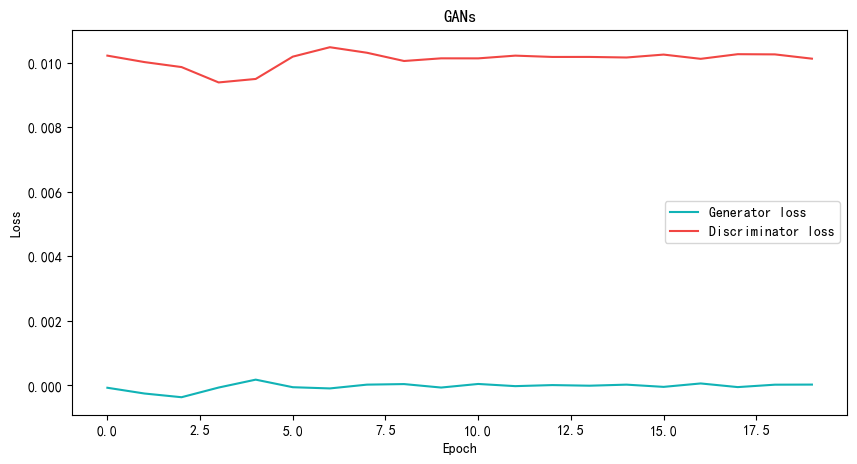

In [217]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 20,
    "verbose": True,
    "plots": True,
}
generator = train(**params3)

## 数据生成

In [218]:
# 生成单步数据
def generator_(data, seq_length, out_dim, num_samples, scaler, model):
    # 设定参数
    batch_size = 1 # 默认每次只生成一组

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    nums = data.shape[0]
    data = scaler.fit_transform(data.values.astype('float32'))

    # 生成新样本
    samples = []
    for i in range(num_samples):
        # 使用模型先跑一组数据，每次跑数据隐藏层维度都会变，会和之后跑的数据分布相同
        k = np.random.randint(0, nums-seq_length) # 随机生成一个整数
        input_data = torch.tensor(data[k:k+seq_length, :]).unsqueeze(0) # 随机抽样
        input_data = input_data.to(device) # 将数据应用到GPU
        # 确保梯度不变
        with torch.no_grad():
            model.eval()
            y_pred = model(input_data) # 使隐藏层输入batch_size变为1
    
        # 在潜在空间中生成一个随机样本
        new_input_data = torch.randn((batch_size, seq_length, out_dim))  
        new_input_data = new_input_data.to(device) 
        with torch.no_grad():
            model.eval()
            generated_samples = model(new_input_data)
            generated_samples = generated_samples[:, -1, :] # 取最后一组数据
            generated_samples = generated_samples.cpu().detach().numpy()
            generated_samples = scaler.inverse_transform(generated_samples) # 反归一化
            samples.append(generated_samples)

    # 重塑维度
    samples = np.squeeze(np.array(samples))
    
    return samples

In [219]:
# 生成时序数据
params6 = {
    "data": ts_data,
    "seq_length": 6,
    "out_dim": 2,
    "num_samples": 3000,
    "scaler": scaler,
    "model": generator,
}
new_data = generator_(**params6)

## 分布差异

<Axes: ylabel='Density'>

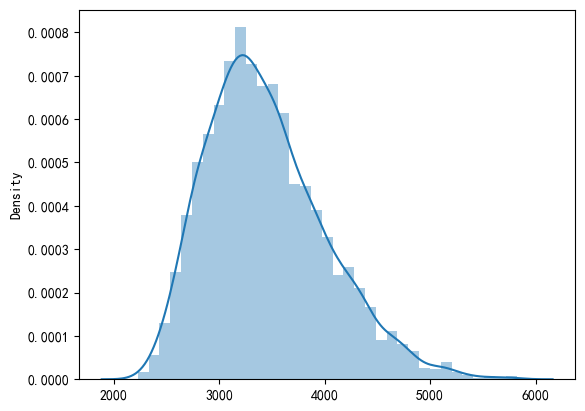

In [220]:
sns.distplot(new_data[:,0]) # 生成的数据分布

<Axes: ylabel='Density'>

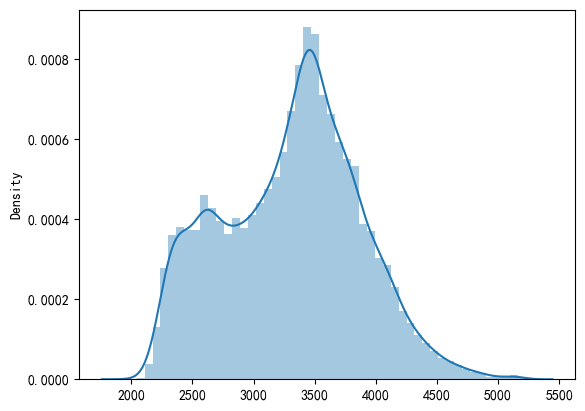

In [221]:
sns.distplot(ts_data['load'].values) # 原始的数据分布

KL散度: 0.1686553660697019


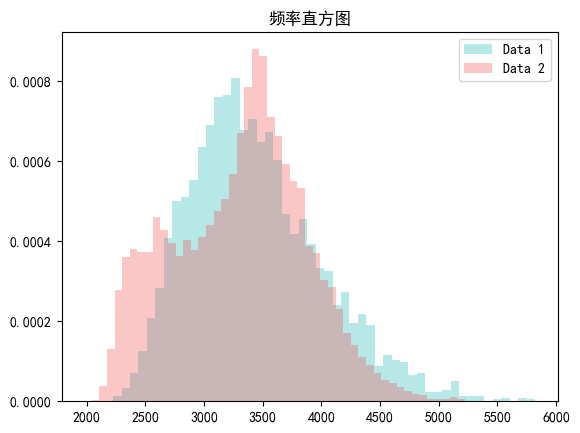

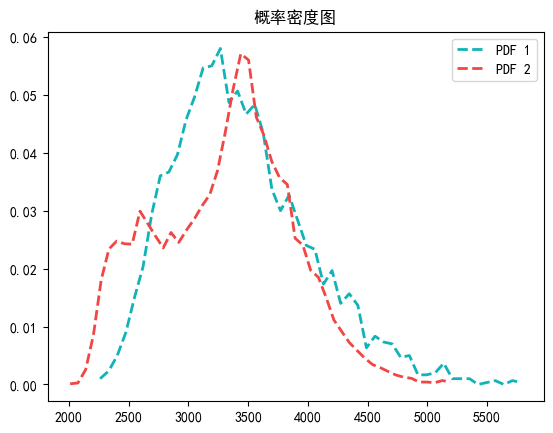

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

np.random.seed(42)
data1 = new_data[:,0]
data2 = ts_data['load'].values

# 生成两个直方图
hist1, bins1 = np.histogram(data1, bins=50, density=True) # hist等于频率/组距
hist2, bins2 = np.histogram(data2, bins=50, density=True)

# 计算每个区间的概率密度
pdf1 = hist1 / np.sum(hist1)
pdf2 = hist2 / np.sum(hist2)

# 计算KL散度
kl_divergence = entropy(pdf1, pdf2)

# 打印结果
print("KL散度:", kl_divergence)

# 绘制直方图和概率密度函数
plt.figure()
plt.hist(data1, bins=bins1, density=True, alpha=0.3, color='#11b3b6', label='Data 1', histtype='stepfilled' )
plt.hist(data2, bins=bins2, density=True, alpha=0.3, color='#f14643', label='Data 2', histtype='stepfilled')
plt.legend() 
plt.title('频率直方图')

plt.figure()
plt.plot((bins1[:-1] + bins1[1:]) / 2, pdf1, color='#11b3b6', linestyle='dashed', linewidth=2, label='PDF 1')
plt.plot((bins2[:-1] + bins2[1:]) / 2, pdf2, color='#f14643', linestyle='dashed', linewidth=2, label='PDF 2')
# 显示图例和标题
plt.legend()
plt.title('概率密度图')

plt.show()

# VAE（变分自编码器）

详见04.时间序列预测

## 数据准备

In [4]:
# 读取数据
def get_dataset(data_path=None, data=None, time_col=None):
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [5]:
data_path = "../test/datasets/energy.csv"
ts_data = get_dataset(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
...,...,...
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00
2014-12-31 22:00:00,"3,499.00",15.33


In [2]:
# 包含时间维度的数据集划分
def divide_dataset(df, test_date, valid_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [61]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [62]:
# 生成tensor数据
def rnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader，drop_last这个是对最后的未完成的batch来说的，后面剩余的不够batch_size的会丢弃
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size, drop_last=False)
    return X, y, loader

In [63]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "step": 1,
    "batch_size": 64,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 2]),y_size: torch.Size([23370, 6, 2]),loader_len: 366
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23


## 结果分析

In [64]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

## 模型训练

In [65]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义变分自编码器模型
    class VAE(nn.Module):
        def __init__(self, input_dim, hidden_dim, latent_dim):
            super(VAE, self).__init__()

            # Encoder
            self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)  # LSTM用于编码输入序列
            self.fc_mean = nn.Linear(hidden_dim*2, latent_dim) # 输出均值
            self.fc_logvar = nn.Linear(hidden_dim*2, latent_dim) # 输出对数方差

            # Decoder
            self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)  # LSTM用于解码潜在表示
            self.fc_output = nn.Linear(hidden_dim*2, input_dim) # 输出重建的序列

        def encode(self, x):
            x, (encoder_hidden, encoder_cell) = self.encoder_lstm(x)  # LSTM编码器的输出
            mean = self.fc_mean(x) # 计算均值
            logvar = self.fc_logvar(x) # 计算对数方差
            return mean, logvar, encoder_hidden, encoder_cell

        def reparameterize(self, mean, logvar):
            std = torch.exp(0.5 * logvar) # 计算标准差
            eps = torch.randn_like(std) # 从标准正态分布中采样噪声，并生成一个与输入张量形状相同的张量，目的是对抗
            return mean + eps * std # 重新参数化，随着损失函数变小，使其服从标准正态分布

        def decode(self, z):
            decoder_hidden, decoder_cell = self.encoder_hidden, self.encoder_cell
            x, _ = self.decoder_lstm(z, (decoder_hidden, decoder_cell))  # z服从标准正态分布
            x = self.fc_output(x) # 输出重建的序列
            return x

        def forward(self, x):
            mean, logvar, self.encoder_hidden, self.encoder_cell = self.encode(x) # 编码输入序列
            z = self.reparameterize(mean, logvar) # 重参数化，形状为(batch_size, seq_length, latent_dim)
            x_recon = self.decode(z) # 解码潜在表示
            return x_recon, mean, logvar

    # 定义变分自编码器的损失函数
    def vae_loss(x_recon, x, mean, logvar):
        # 重建损失（MSE损失）
        recon_loss = nn.functional.mse_loss(x_recon, x)

        # KL散度损失，KL散度通常用于衡量潜在空间中的编码分布与先验分布（通常是标准正态分布）之间的差异。
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) # 散度越小意味着两个分布越接近

        return recon_loss + kl_loss
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    input_dim = 2  # 输入数据的维度
    hidden_dim = 64  # LSTM层的隐藏单元数
    latent_dim = 16  # 潜在空间的维度
    model = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            x_recon, mean, logvar = model(inputs_batch)
            train_loss = vae_loss(x_recon, inputs_batch, mean, logvar)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                x_recon, mean, logvar = model(inputs_batch)
                val_loss = vae_loss(x_recon, inputs_batch, mean, logvar)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:05<00:48,  5.41s/it]

Epoch [1/10], Training Loss: 0.2539, Validation Loss: 0.0101


 20%|████████████████▌                                                                  | 2/10 [00:11<00:44,  5.58s/it]

Epoch [2/10], Training Loss: 0.0027, Validation Loss: 0.0036


 30%|████████████████████████▉                                                          | 3/10 [00:16<00:39,  5.66s/it]

Epoch [3/10], Training Loss: 0.0015, Validation Loss: 0.0028


 40%|█████████████████████████████████▏                                                 | 4/10 [00:22<00:34,  5.72s/it]

Epoch [4/10], Training Loss: 0.0011, Validation Loss: 0.0023


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:28<00:28,  5.78s/it]

Epoch [5/10], Training Loss: 0.0009, Validation Loss: 0.0019


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:34<00:23,  5.79s/it]

Epoch [6/10], Training Loss: 0.0007, Validation Loss: 0.0017


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:40<00:17,  5.76s/it]

Epoch [7/10], Training Loss: 0.0007, Validation Loss: 0.0015


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:45<00:11,  5.76s/it]

Epoch [8/10], Training Loss: 0.0006, Validation Loss: 0.0015


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:51<00:05,  5.77s/it]

Epoch [9/10], Training Loss: 0.0006, Validation Loss: 0.0014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.73s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0013


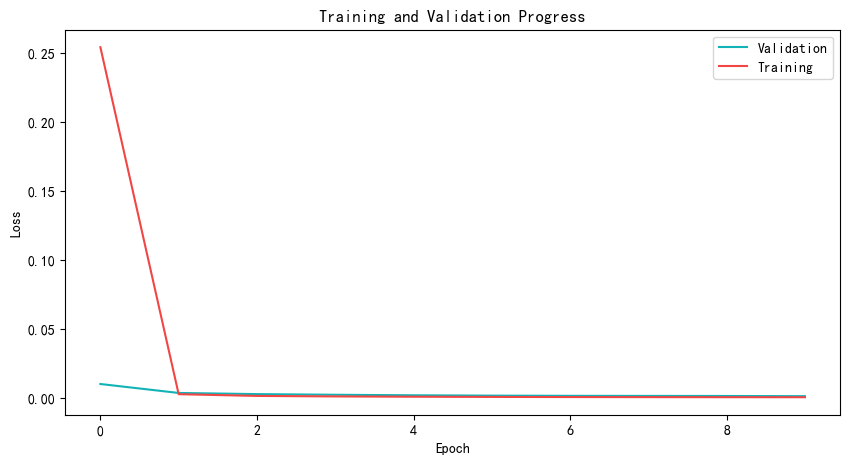

In [66]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "plots": True,
}
model = train(**params3)

## 数据生成

In [67]:
# 生成单步数据
def generator(data, seq_length, latent_dim, num_samples, scaler, model):
    # 设定参数
    batch_size = 1 # 默认每次只生成一组
    seq_length = seq_length
    latent_dim = latent_dim

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    nums = data.shape[0]
    data = scaler.fit_transform(data.values.astype('float32'))

    # 生成新样本
    samples = []
    for i in range(num_samples):
        # 使用模型先跑一组数据，每次跑数据隐藏层维度都会变，会和之后跑的数据分布相同
        k = np.random.randint(0, nums-seq_length) # 随机生成一个整数
        input_data = torch.tensor(data[k:k+seq_length, :]).unsqueeze(0) # 随机抽样
        input_data = input_data.to(device) # 将数据应用到GPU
        with torch.no_grad():
            model.eval()
            y_pred, mean, logvar = model(input_data) # 使隐藏层输入batch_size变为1
    
        # 在潜在空间中生成一个随机样本
        new_input_data = torch.randn((batch_size, seq_length, latent_dim))  
        new_input_data = new_input_data.to(device) 
        with torch.no_grad():
            model.eval()
            generated_samples = model.decode(new_input_data)
            generated_samples = generated_samples[:, -1, :] # 取最后一组数据
            generated_samples = generated_samples.cpu().detach().numpy()
            generated_samples = scaler.inverse_transform(generated_samples) # 反归一化
            samples.append(generated_samples)

    # 重塑维度
    samples = np.squeeze(np.array(samples))
    
    return samples

In [68]:
# 生成时序数据
params6 = {
    "data": ts_data,
    "seq_length": 6,
    "latent_dim": 16,
    "num_samples": 3000,
    "scaler": scaler,
    "model": model,
}
new_data = generator(**params6)

## 分布差异

<Axes: ylabel='Density'>

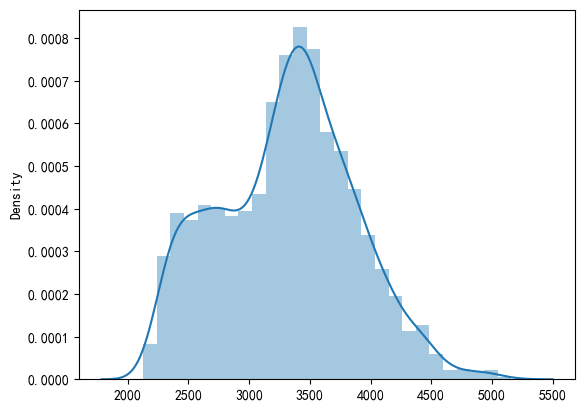

In [72]:
sns.distplot(new_data[:,0]) # 生成的数据分布

<Axes: ylabel='Density'>

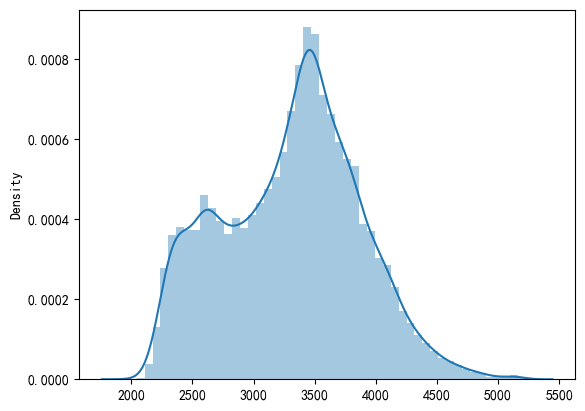

In [73]:
sns.distplot(ts_data['load'].values) # 原始的数据分布

KL散度: 0.06708296180865164


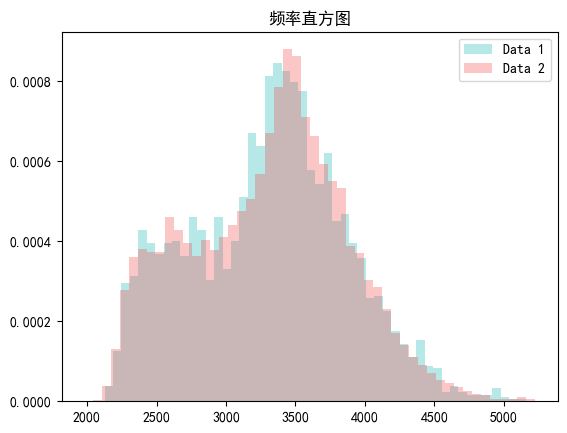

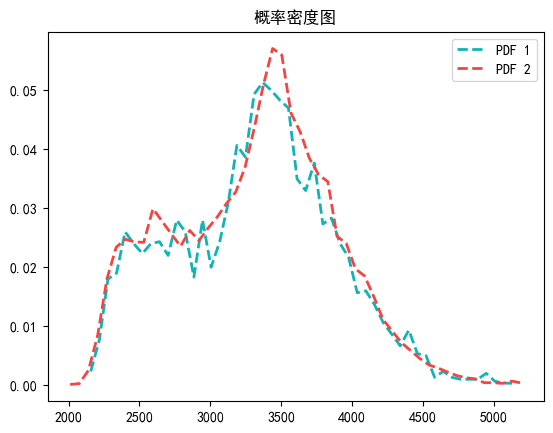

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

np.random.seed(42)
data1 = new_data[:,0]
data2 = ts_data['load'].values

# 生成两个直方图
hist1, bins1 = np.histogram(data1, bins=50, density=True) # hist等于频率/组距
hist2, bins2 = np.histogram(data2, bins=50, density=True)

# 计算每个区间的概率密度
pdf1 = hist1 / np.sum(hist1)
pdf2 = hist2 / np.sum(hist2)

# 计算KL散度
kl_divergence = entropy(pdf1, pdf2)

# 打印结果
print("KL散度:", kl_divergence)

# 绘制直方图和概率密度函数
plt.figure()
plt.hist(data1, bins=bins1, density=True, alpha=0.3, color='#11b3b6', label='Data 1', histtype='stepfilled' )
plt.hist(data2, bins=bins2, density=True, alpha=0.3, color='#f14643', label='Data 2', histtype='stepfilled')
plt.legend() 
plt.title('频率直方图')

plt.figure()
plt.plot((bins1[:-1] + bins1[1:]) / 2, pdf1, color='#11b3b6', linestyle='dashed', linewidth=2, label='PDF 1')
plt.plot((bins2[:-1] + bins2[1:]) / 2, pdf2, color='#f14643', linestyle='dashed', linewidth=2, label='PDF 2')
# 显示图例和标题
plt.legend()
plt.title('概率密度图')

plt.show()